# Depression Detection through social media Tweets

## Import libraries

In [1]:
# Import necessary libraries
# %%capture hides the output on console

%%capture
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.model_selection import train_test_split

# Text Pre-processing libraries
import nltk
import string
import warnings
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud

# Tensorflow imports to build the model.
import tensorflow as tf
from tensorflow import keras
from keras import layers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

nltk.download('stopwords')
nltk.download('omw-1.4')
nltk.download('wordnet')
warnings.filterwarnings('ignore')

## Load and process dataset

In [2]:
# Loading the dataset
df = pd.read_csv('dataset/hate_speech.csv')
df.head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [3]:
# Drop unnecessary columns
df = df.drop(columns=['Unnamed: 0', 'count', 'hate_speech', 'offensive_language', 'neither'])

In [4]:
df.head()
# Class 0: Hate
# Class 1: Offensive
# Class 2: Neutral

,class,tweet
0,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [5]:
# Checking how many tweets we have
print(df.shape)

(24783, 2)


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24783 entries, 0 to 24782
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   class   24783 non-null  int64 
 1   tweet   24783 non-null  object
dtypes: int64(1), object(1)
memory usage: 387.4+ KB


The shape of the data frame and the number of non-null values are the same hence we can say that there are no null values in the dataset.

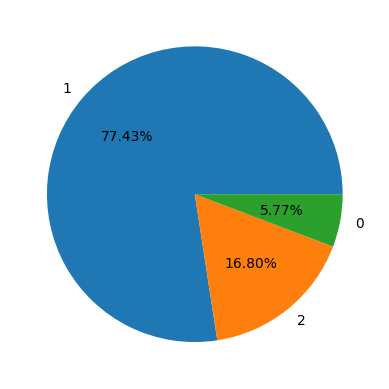

In [7]:
plt.pie(df['class'].value_counts().values,
        labels = df['class'].value_counts().index,
        autopct='%.2f%%')
plt.show()

Here the three labels are as follows:
```
0 is Hate Speech
1 is Offensive Language
2 is Neither
```

## Text preprocessing

### 1) Punctuation Removal

In [8]:
# Lower case all the words of the tweet before any preprocessing
df['tweet'] = df['tweet'].str.lower()

# Removing punctuations present in the text
punctuations_list = string.punctuation
def remove_punctuations(text):
    temp = str.maketrans('', '', punctuations_list)
    return text.translate(temp)

df['tweet']= df['tweet'].apply(lambda x: remove_punctuations(x))
df.head()

,class,tweet
0,2,rt mayasolovely as a woman you shouldnt compl...
1,1,rt mleew17 boy dats coldtyga dwn bad for cuff...
2,1,rt urkindofbrand dawg rt 80sbaby4life you eve...
3,1,rt cganderson vivabased she look like a tranny
4,1,rt shenikaroberts the shit you hear about me ...


### 2) Remove stop words and lemmatize remaining words

In [9]:
def remove_stopwords(text):
    stop_words = stopwords.words('english')
    lemmatizer = WordNetLemmatizer()

    imp_words = []

    # Storing the important words
    for word in str(text).split():

        if word not in stop_words:

            # Let's Lemmatize the word as well
            # before appending to the imp_words list.
            lemmatizer.lemmatize(word)

            imp_words.append(word)

    output = " ".join(imp_words)

    return output


df['tweet'] = df['tweet'].apply(lambda text: remove_stopwords(text))
df.head()

,class,tweet
0,2,rt mayasolovely woman shouldnt complain cleani...
1,1,rt mleew17 boy dats coldtyga dwn bad cuffin da...
2,1,rt urkindofbrand dawg rt 80sbaby4life ever fuc...
3,1,rt cganderson vivabased look like tranny
4,1,rt shenikaroberts shit hear might true might f...


Word cloud is a text visualization tool that help’s us to get insights into the most frequent words present in the corpus of the data.

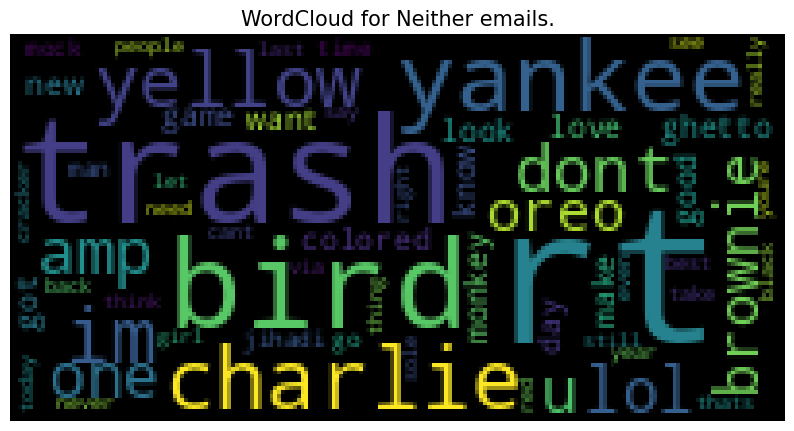

In [10]:
def plot_word_cloud(data, typ):
  # Joining all the tweets to get the corpus
  email_corpus = " ".join(data['tweet'])

  plt.figure(figsize = (10,10))

  # Forming the word cloud
  wc = WordCloud(max_words = 100,
                width = 200,
                height = 100,
                collocations = False).generate(email_corpus)

  # Plotting the wordcloud obtained above
  plt.title(f'WordCloud for {typ} emails.', fontsize = 15)
  plt.axis('off')
  plt.imshow(wc)
  plt.show()
  print()

plot_word_cloud(df[df['class']==2], typ='Neither')

### 3) Dealing with imbalanced class distributions

In [11]:
class_2 = df[df['class'] == 2]
class_1 = df[df['class'] == 1].sample(n=3500)
class_0 = df[df['class'] == 0]

print(class_2.shape)
print(class_1.shape)
print(class_0.shape)

(4163, 2)
(3500, 2)
(1430, 2)


In [12]:
balanced_df = pd.concat([class_0, class_0, class_0, class_1, class_2], axis=0)

Now let’s check what is the data distribution in the three classes.

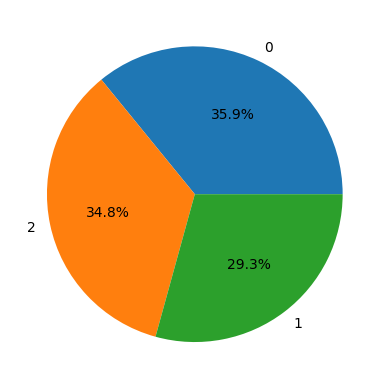

In [13]:
plt.pie(balanced_df['class'].value_counts().values,
        labels=balanced_df['class'].value_counts().index,
        autopct='%1.1f%%')
plt.show()

## Word2Vec Conversion

In [14]:
features = balanced_df['tweet']
target = balanced_df['class']

X_train, X_val, Y_train, Y_val = train_test_split(features,
                                                  target,
                                                  test_size=0.2,
                                                  random_state=22)
X_train.shape, X_val.shape

((9562,), (2391,))

In [15]:
# Doing one-hot encoding of labels
Y_train = pd.get_dummies(Y_train)
Y_val = pd.get_dummies(Y_val)
Y_train.shape, Y_val.shape

((9562, 3), (2391, 3))

In [16]:
# training the tokenizer
max_words = 5000
token = Tokenizer(num_words=max_words,
                  lower=True,
                  split=' ')
token.fit_on_texts(X_train)

# Generating token embeddings
Training_seq = token.texts_to_sequences(X_train)
Training_pad = pad_sequences(Training_seq,
                             maxlen=50,
                             padding='post',
                             truncating='post')

Testing_seq = token.texts_to_sequences(X_val)
Testing_pad = pad_sequences(Testing_seq,
                            maxlen=50,
                            padding='post',
                            truncating='post')

print(Training_pad.shape)

(9562, 50)


## Model Development and Evaluation

We will implement a Sequential model which will contain the following parts:

* An Embedding Layer to learn a featured vector representations of the input vectors.
* A Bidirectional LSTM layer to identify useful patterns in the sequence.
* Then we will have one fully connected layer.
* We have included some BatchNormalization layers to enable stable and fast training and a Dropout layer before the final layer to avoid any possibility of overfitting.
* The final layer is the output layer which outputs soft probabilities for the three classes.

In [17]:
max_len = 50

model = keras.models.Sequential([
    layers.Embedding(max_words, 32, input_length=max_len),
    layers.Bidirectional(layers.LSTM(16)),
    layers.Dense(512, activation='relu', kernel_regularizer='l1'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(3, activation='softmax')
])

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 32)            160000    
                                                                 
 bidirectional (Bidirection  (None, 32)                6272      
 al)                                                             
                                                                 
 dense (Dense)               (None, 512)               16896     
                                                                 
 batch_normalization (Batch  (None, 512)               2048      
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 3)                 1

Note that when model outputs softmax probabilities and true labels are one-hot-encoded, then we use `Categorical Cross-entropy` as our loss function.

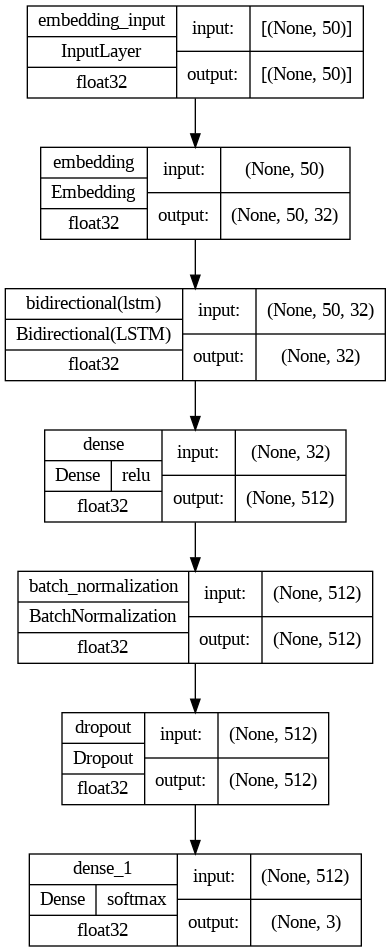

In [18]:
keras.utils.plot_model(
    model,
    show_shapes=True,
    show_dtype=True,
    show_layer_activations=True
)

In [19]:
# Setting up callbacks
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

es = EarlyStopping(patience=3,
                   monitor = 'val_accuracy',
                   restore_best_weights = True)

lr = ReduceLROnPlateau(patience = 2,
                       monitor = 'val_loss',
                       factor = 0.5,
                       verbose = 0)

In [20]:
# Training the model
history = model.fit(Training_pad, Y_train,
                    validation_data=(Testing_pad, Y_val),
                    epochs=50,
                    verbose=1,
                    batch_size=32,
                    callbacks=[lr, es])

Epoch 1/50
299/299 [==============================] - 34s 77ms/step - loss: 1.7525 - accuracy: 0.7642 - val_loss: 0.9684 - val_accuracy: 0.6453 - lr: 0.0010
Epoch 2/50
299/299 [==============================] - 5s 17ms/step - loss: 0.3691 - accuracy: 0.9014 - val_loss: 0.5194 - val_accuracy: 0.8628 - lr: 0.0010
Epoch 3/50
299/299 [==============================] - 4s 15ms/step - loss: 0.2681 - accuracy: 0.9339 - val_loss: 0.6479 - val_accuracy: 0.8172 - lr: 0.0010
Epoch 4/50
299/299 [==============================] - 4s 14ms/step - loss: 0.2207 - accuracy: 0.9515 - val_loss: 0.4695 - val_accuracy: 0.8816 - lr: 0.0010
Epoch 5/50
299/299 [==============================] - 4s 14ms/step - loss: 0.1883 - accuracy: 0.9592 - val_loss: 0.5139 - val_accuracy: 0.8783 - lr: 0.0010
Epoch 6/50
299/299 [==============================] - 4s 13ms/step - loss: 0.1580 - accuracy: 0.9652 - val_loss: 0.5764 - val_accuracy: 0.8532 - lr: 0.0010
Epoch 7/50
299/299 [==============================] - 4s 13ms/s

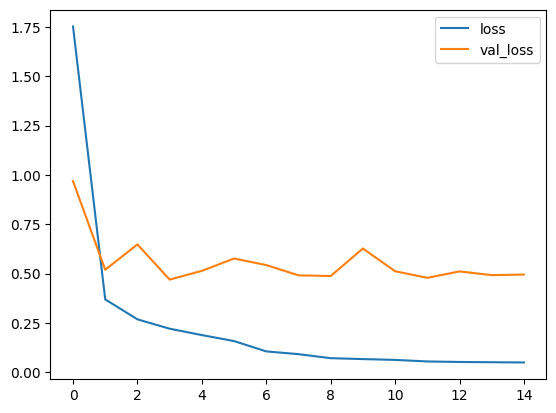

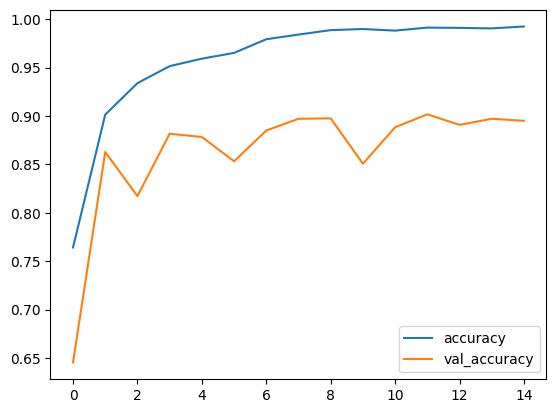

In [21]:
# Plotting the history
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
history_df.loc[:, ['accuracy', 'val_accuracy']].plot()
plt.show()

## Saving artifacts and coding inference Pipeline

In [22]:
# Save the tokenizer to a file
with open('tokenizer.pkl', 'wb') as token_file:
    pickle.dump(token, token_file)

In [23]:
# Save the model
model.save('mood_detector')

In [26]:
def detect_depression(text):
  '''
  text is a list of string.
  returns: whether the person is normal or is in depression
  '''

  # Load the mood detector
  mood_detector = tf.keras.models.load_model("mood_detector")

  # Load the tokenizer from the saved file
  with open('tokenizer.pkl', 'rb') as token_file:
      loaded_tokenizer = pickle.load(token_file)

  # Tokenize new text data using the loaded tokenizer
  text_seq = loaded_tokenizer.texts_to_sequences(text)
  text_pad = pad_sequences(text_seq, maxlen=50, padding='post', truncating='post')

  # Predict
  predictions = mood_detector.predict(text_pad)

  ''' If hate probability is greater than 80% and offensive probability is
  greater than 70%, only then we'll declare that the person who posted the
  content is in state of depression.'''

  if predictions[0][0] > 0.8 and predictions[0][1] > 0.7:
    print("This person is in Depression!")
  else:
    print("This person is in Normal state!")

In [27]:
detect_depression(["I love good food sooo much oh mai gooood :)"])

1/1 [==============================] - 1s 682ms/step
This person is in Normal state!


## Downloading the model in Google drive

In [28]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [29]:
import shutil

source_folder = '/content/mood_detector'
destination_folder = '/content/drive/My Drive/'

# Copy the folder to Google Drive
shutil.copytree(source_folder, destination_folder + 'mood_detector')


'/content/drive/My Drive/mood_detector'